<a href="https://colab.research.google.com/github/DoubleCyclone/house-price-prediction/blob/main/notebooks/house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I will be working with the "**House Prices - Advanced Regression Techniques**" dataset today to perform
*   Exploratory Data Analysis
*   Data Preprocessing
*   Feature Engineering
*   Model Building
*   Evaluation
*   and Visualisation

First things first, I am going to mount google drive so that I can upload the dataset there and easily access it from the notebook.

The dataset (and the competition) is at [Kaggle Competition/Dataset Link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

In [3]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
# Let's import the other dependencies as well
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
import warnings
warnings.filterwarnings('ignore')

# 1 - Exploratory Data Analysis
I will start by reading the train.csv which is the training dataset and displaying a small portion of it.

In [5]:
# Load the training and test datasets, examine their shapes and contents
data_train = pd.read_csv('/content/drive/MyDrive/Colab_Materials/House_Price_Estimation/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Colab_Materials/House_Price_Estimation/test.csv')
# I will drop the ID columns as they are not used for training models
data_train = data_train.drop('Id', axis=1)
data_test = data_test.drop('Id', axis=1)

print(f"Shape of the train dataset = {data_train.shape}")
data_train.head()

Shape of the train dataset = (1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
print(f"Shape of the test dataset = {data_test.shape}")
data_test.head()

Shape of the test dataset = (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Seems like there are almost an equal amount of data in both datasets. There is also one more column in the train dataset called **SalePrice** is the sale price which will be the labels the model will learn from in this case. How about getting an idea of its distribution in the dataset?

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


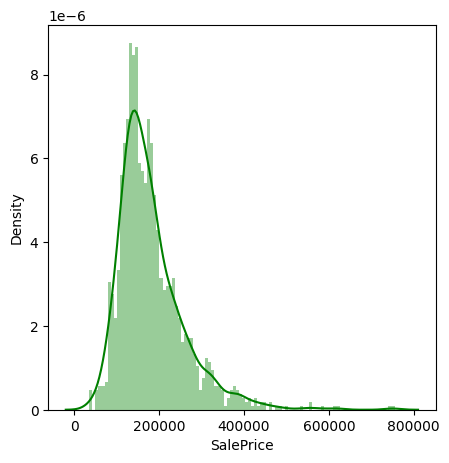

In [118]:
# Use the pandas.describe method to automatically generate valuable information about the dataset (only for a numerical variable in this case)
print(data_train['SalePrice'].describe())

# Plot the distribution of the SalePrice column
plt.figure(figsize=(5, 5))
sns.distplot(data_train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

# Move the SalePrice (label)
data_y = data_train['SalePrice']

# Drop label from the DataFrame
data_train.drop('SalePrice', axis=1, inplace=True)

By looking at the output of the pandas.describe function and the graph, we can see that most of the Sale Prices reside at around 180000 and the standard deviation is quite low. Meaning that the data has low variability. How do I decide if the standard deviation is low or not? Firstly, I calculate the range of the data which is **max - min**. In this case **755000 - 34900 = 720100**. If the standard deviation is close to the range, I can say that the variability is high but in our case, standard deviation is approximately 10x lesser than the range which lets us conclude that the standard deviation, thus the variability in Sale Prices is low. <br><br>
Now let's see what type of data is stored in the training dataset.

In [119]:
# Print the list of unique data types
list(set(data_train.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

Now let's store the numerical data in a new DataFrame so that we can use it easily.

In [120]:
# Create a new DataFrame for numerical data only
train_num = data_train.select_dtypes(include = ['float64', 'int64'])
train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


While at that, let's plot the distributions of all these numerical features at the same time.

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

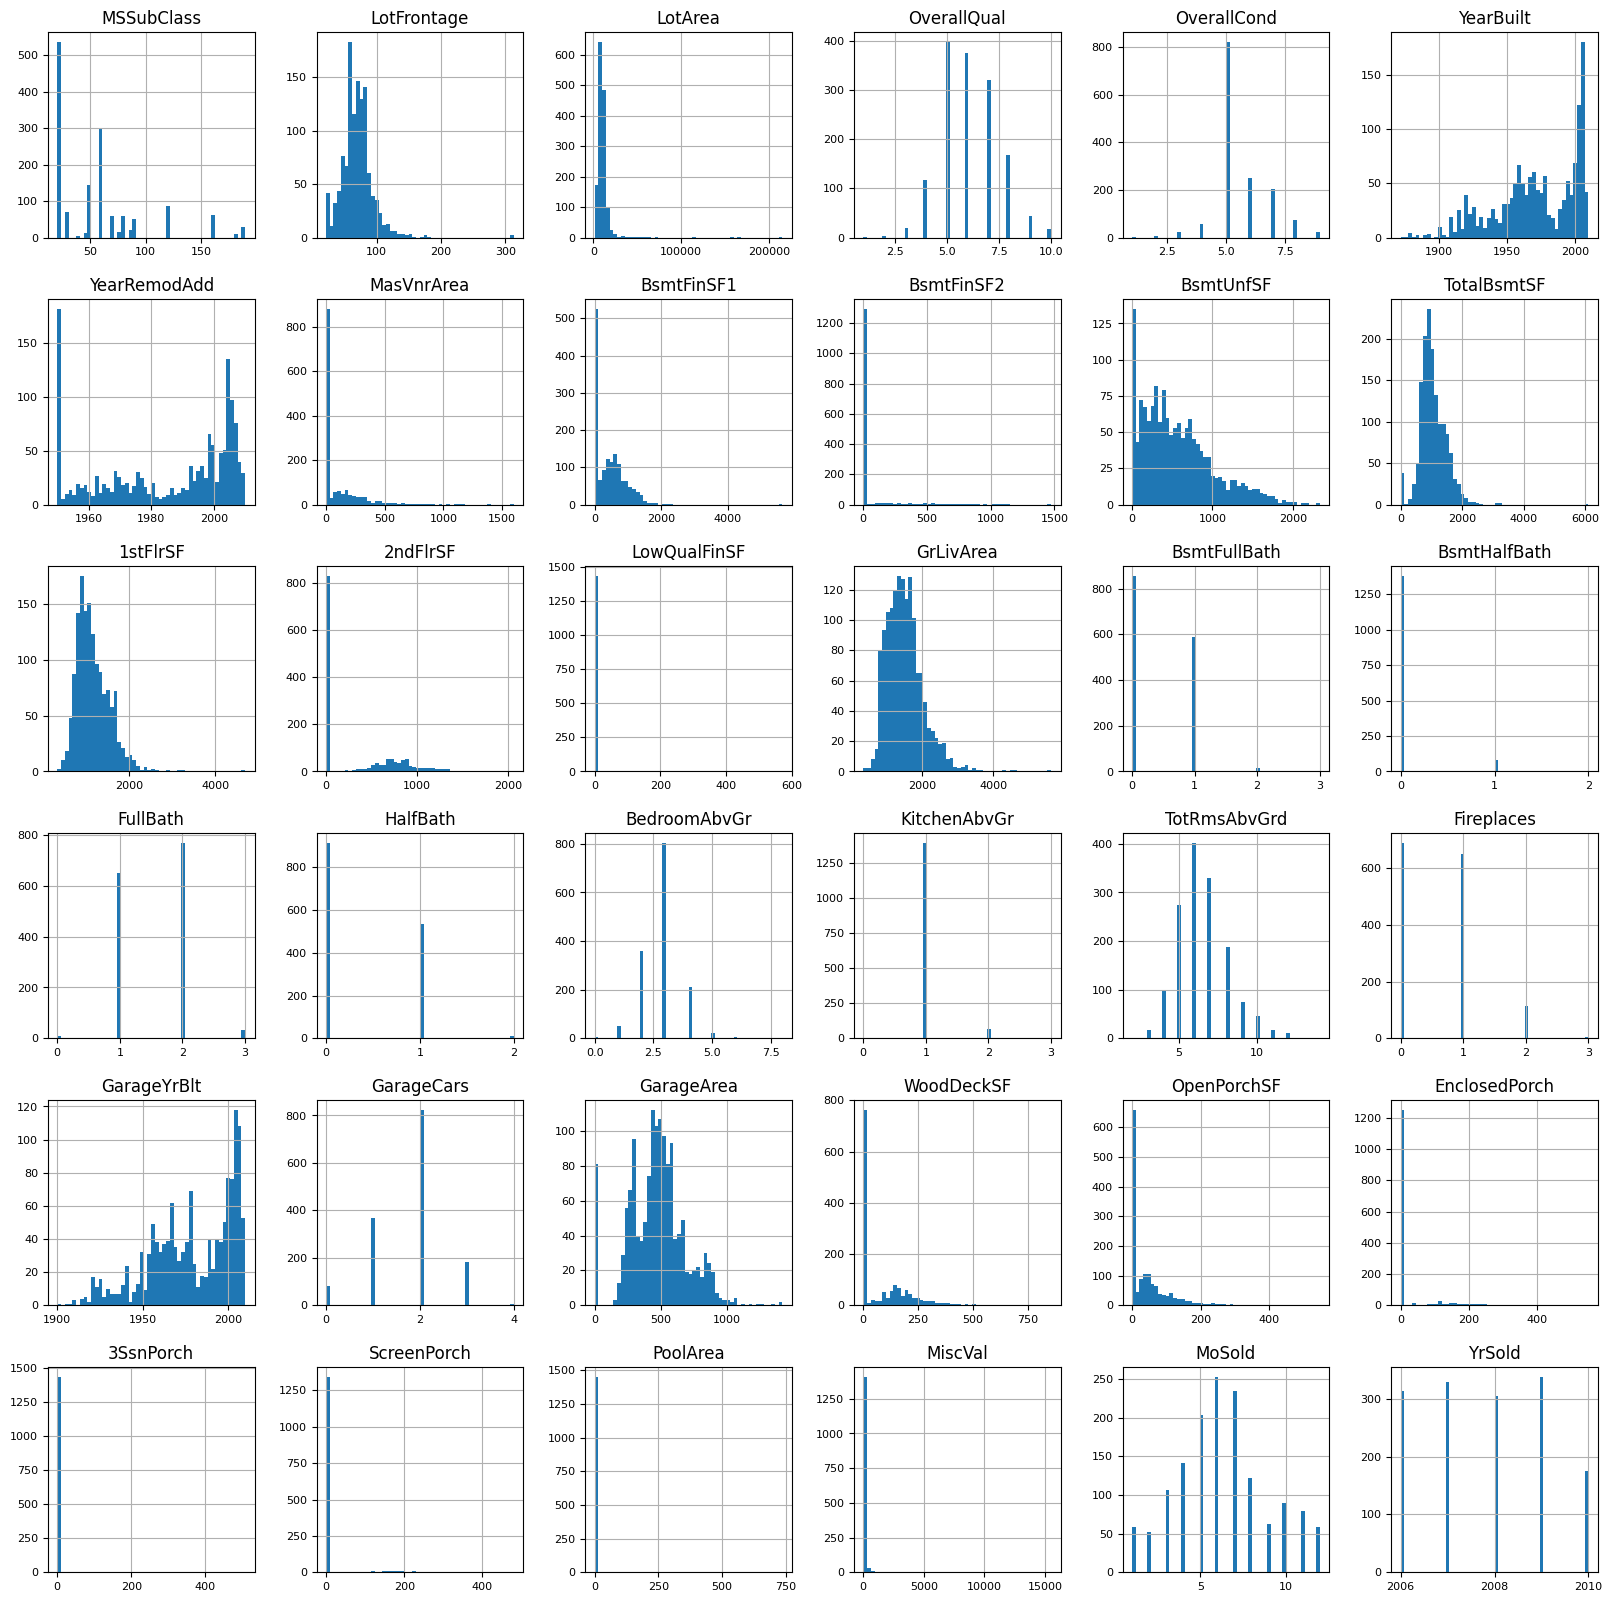

In [122]:
train_num.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)

I considered removing some of these columns if they could be unrelated to a house's sale price but I think all of these are useful so they will be kept. Let's take a look at the categorical features this time.

In [123]:
# Create a new DataFrame for categorical data only
train_cat = data_train.select_dtypes(include = ['O'])
train_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


Seems like most of our features are categorical. Let's plot their distributions as well.

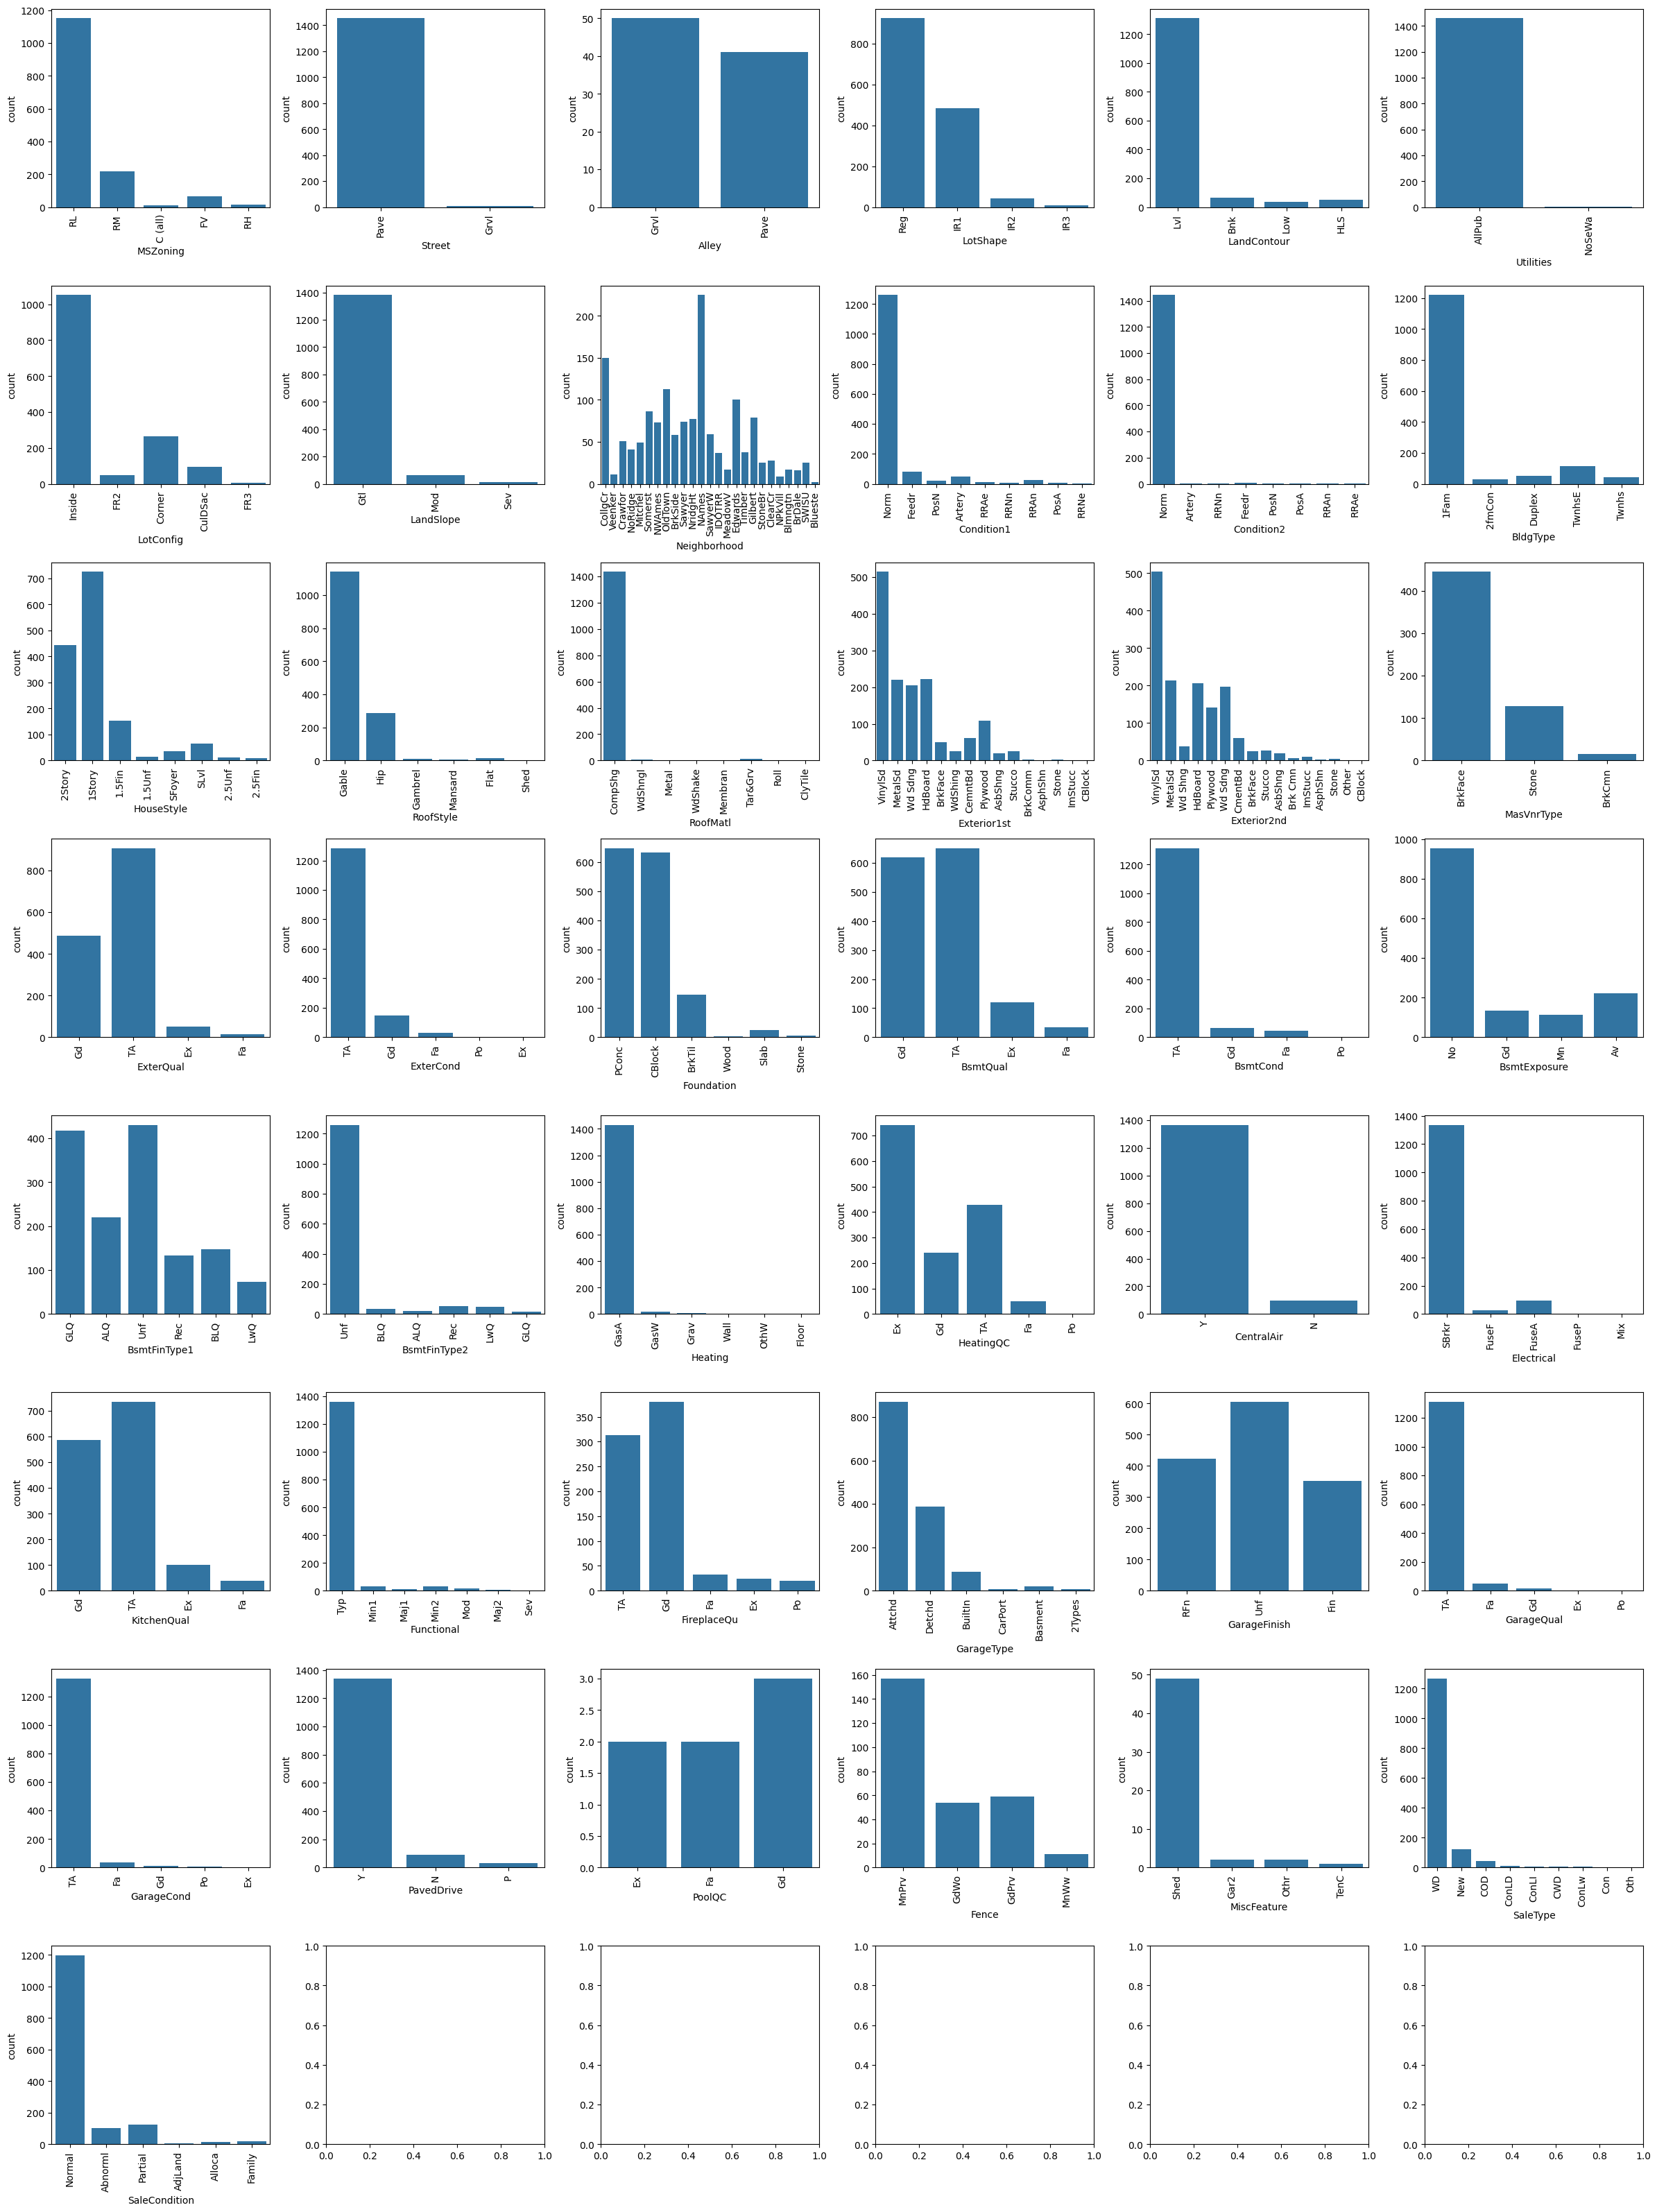

In [124]:
# Create a composed plot with matplotlib.subplots()
fig, axs = plt.subplots(8, 6, figsize=(24, 32))

# Flatten the axes so that iterating is easier
axs = axs.flatten()

# Iterate through each feature/column and plot their countplots
for i, col in enumerate(train_cat.columns):
  sns.countplot(x=train_cat[col], ax=axs[i])
  axs[i].tick_params(axis='x', rotation=90)

# Use matplotlib.tight_layout() to prevent overlapping
fig.tight_layout()


As it is not desirable to directly enumerate categorical values. For example, it does not make sense to give paved a value of 0 and gravel a value of 1 for the **Street** feature. We would rather use an approach called **One-Hot Encoding** which is basically to give every unique entry its own binary value like;
* Paved = 1
* Gravel = 0

so that this means there is a paved street and not gravel around the house. It should be noted that only one of these values can be 1 (True) at a time but all can be 0 (False) if that entry is missing. <br><br>
Also, numerical features' ranges vary by a large margin in the dataset. If we take a look at the features like **FullBath** which is a number of full bathrooms above grade and **TotalLotArea** which can get a value up to 200000~ as can be seen from the plots. So we should definitely normalize the numerical features so that we end up with values that are standardized. For example, limiting their range to 0-1 interval. <br>
This
* helps models converge faster
* prevents the **NaN** trap which is when a value exceeds the floating point precision limit so that eventually every number in the model became **NaN**

There are a few normalization methods in my mind so let's try to decide on which one would be the best fit for our dataset.
- **Linear Scaling** : Best when
  - there are few or no outliers, and the outliers aren't extreme.
  - distribution of the data is approximately uniform.
- **Z-Score Scaling** : Best when
  - the distribution resembles a normal distribution or something close to it.
- **Log Scaling** : Best when
  - low values of x have very high values of y
  - as the values of x increase, values of y quickly decrease
  
I might use something completely different who knows...

# 2 - Data Preprocessing
This has been a huge information dump but lets just examine what portion of each feature is missing now to see if we want to remove anything.

In [125]:
# Use the DataFrame.isna().sum() with a condition to get all the counts of nan values for every column that has at least one, then turn it into a percentage
train_num.isna().sum()[data_train.isna().sum() > 0] / len(data_train) * 100

,0
LotFrontage,17.739726
MasVnrArea,0.547945
GarageYrBlt,5.547945


In [126]:
# Do the same with categorical features
train_cat.isna().sum()[data_train.isna().sum() > 0] / len(data_train) * 100

,0
Alley,93.767123
MasVnrType,59.726027
BsmtQual,2.534247
BsmtCond,2.534247
BsmtExposure,2.602740
BsmtFinType1,2.534247
BsmtFinType2,2.602740
Electrical,0.068493
FireplaceQu,47.260274
GarageType,5.547945


Turns out most of the features that can take the value of **NaN** are categorical and it makes sense. A house does not necessarily have to have Pool for example so it can have a value of 0 for each **One-Hot Encoded** feature. Even the numerical data makes sense as if a property does not have a garage for example, it should not have a **GarageYrBlt** value. I do not see any problem with the dataset so the I will not be removing any rows from it. If let's say the **SalePrice** was ever **NaN**, we would be removing the data as the model cannot learn anything from that entry as the losses will be calculated based on the inputs (every other column) and the label (**SalePrice** column). <br><br>
As it is the easiest part, let's turn categorical features into One-Hot Encodings.


In [127]:
# Get the categorical columns
categorical_columns = train_cat.columns.tolist()

# Specify encoder
encoder = OneHotEncoder(sparse_output=False)

# Create a Tensor for the one-hot-encoded features
one_hot_encoded = encoder.fit_transform(data_train[categorical_columns])

# Create a DataFrame from the Tensor with the appropriate column names
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Display a portion of it
one_hot_df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_nan,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Now we have 267 columns of **True** or **False** values for categorical features. For the next step, let's try to use Scikit-Learn's PowerTransformer to normalize the data instead of the other three methods as I don't think any of them fit well to all (or even most) features.

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

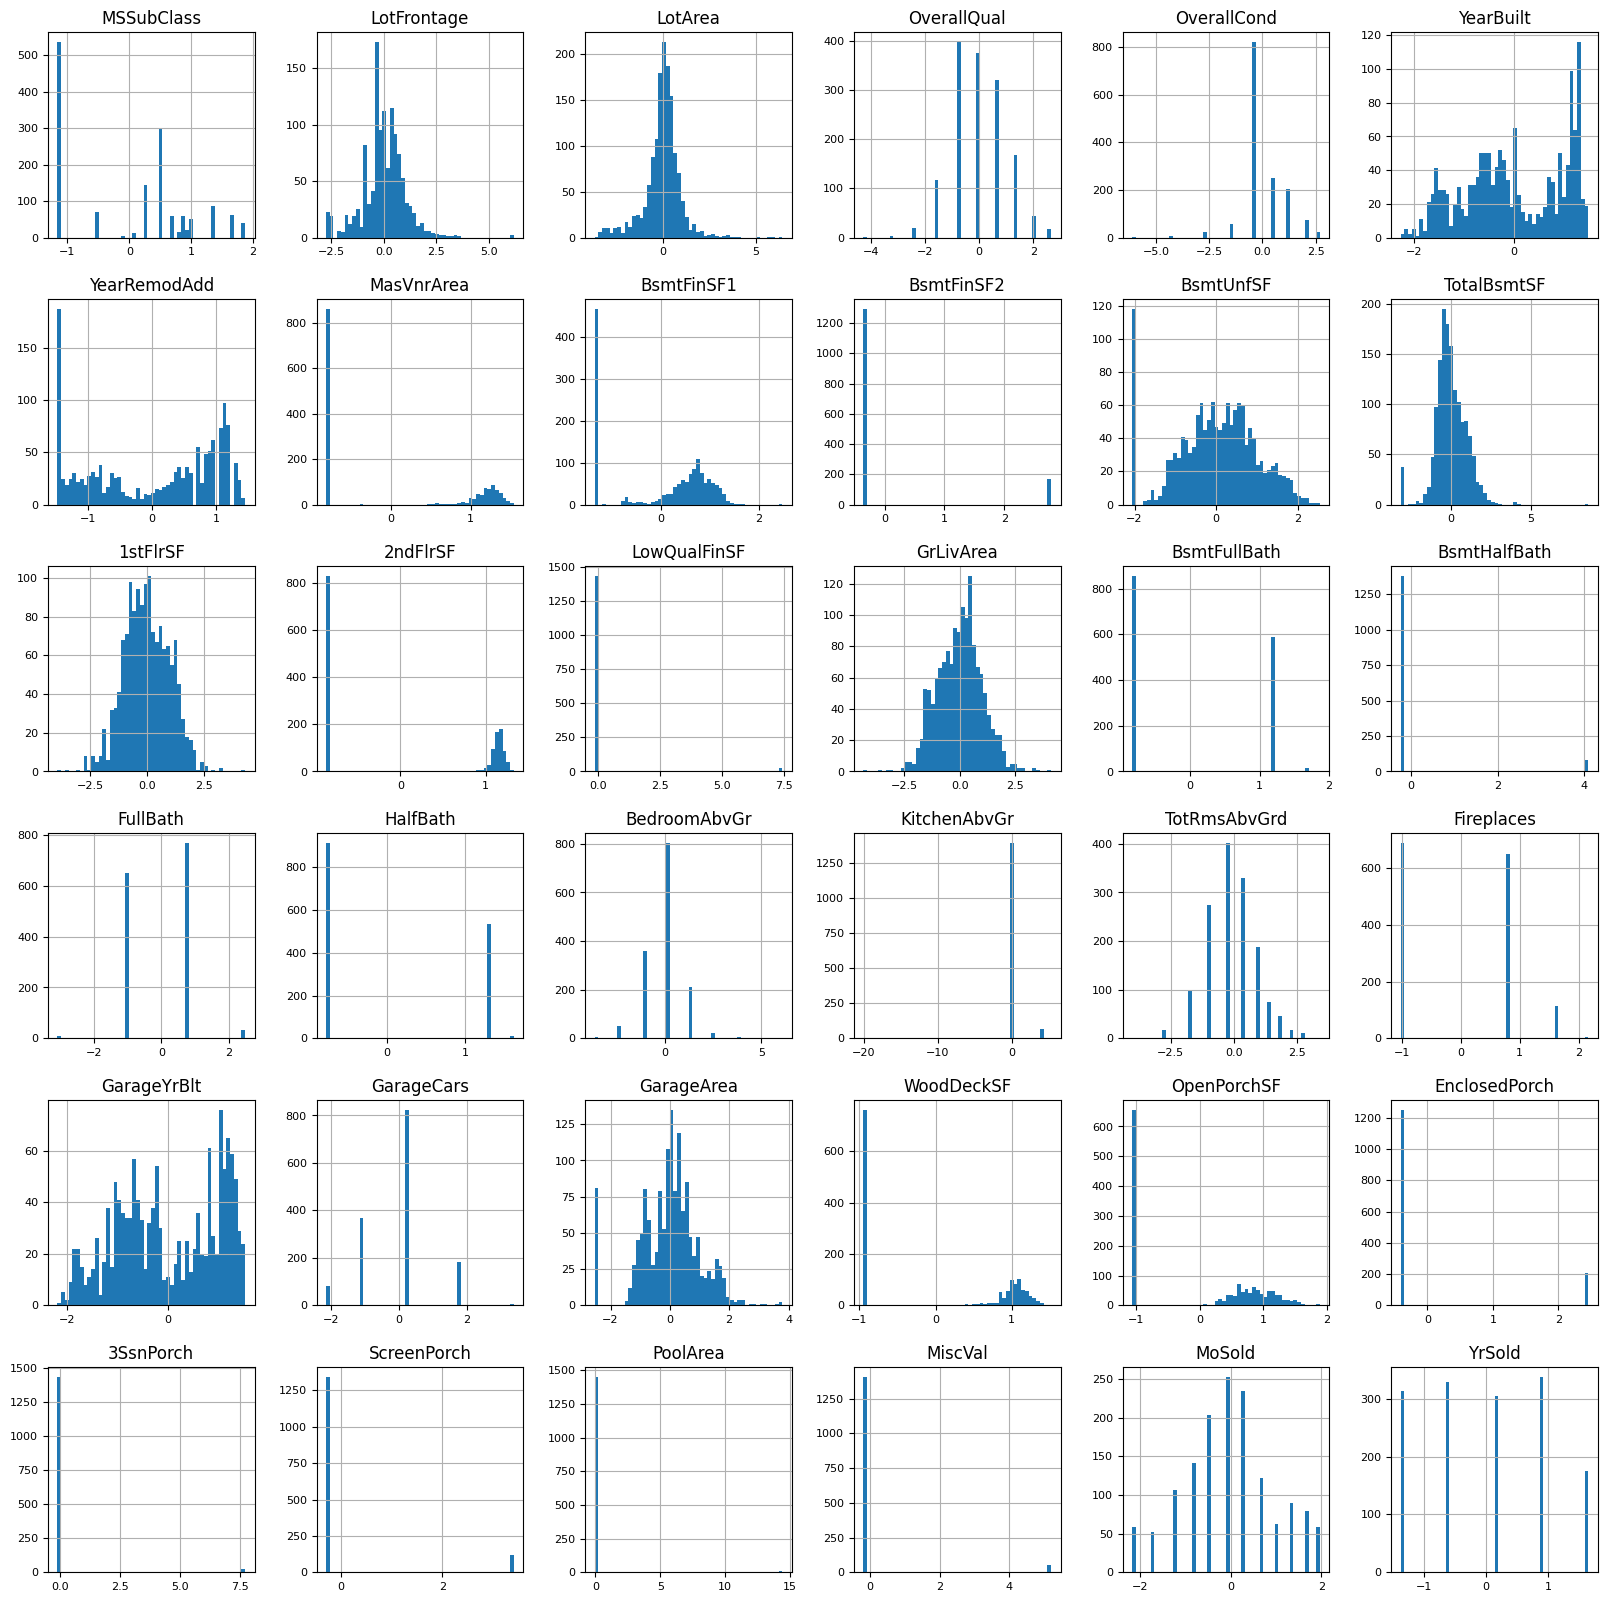

In [129]:
# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Transform only the numerical the data
train_num_normalized = pd.DataFrame(pt.fit_transform(train_num), columns=pt.get_feature_names_out(train_num.columns))

# Plot them after the transformation
train_num_normalized.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)

These distributions look a lot better than how they were originally. The scale problem is solved as all the numerical features now span a similar range. Finally let's create the actual training dataset that we are going to use to train models.

In [132]:
# Concatenate the scaled numerical features and one-hot-encoded categorical values
data_train_normalized = pd.concat([train_num_normalized, one_hot_df], axis=1)

# Display a portion of it
data_train_normalized.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.493460,-0.118925,-0.141171,0.667499,-0.477387,1.151867,0.908055,1.224910,0.797537,-0.359384,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.164269,0.508345,0.105609,-0.042192,2.011352,0.006695,-0.621670,-0.822092,1.011471,-0.359384,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.493460,0.013008,0.413721,0.667499,-0.477387,1.055357,0.835594,1.187565,0.571325,-0.359384,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.698191,-0.347206,0.095490,0.667499,-0.477387,-1.629540,-0.863478,-0.822092,0.142272,-0.359384,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.493460,0.663404,0.877127,1.350924,-0.477387,1.007861,0.694898,1.328843,0.750541,-0.359384,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
